<center>
    <img src="./images/mlfasp.png">
</center>

#### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta

[Applied Media Systems Group](https://www.tu-ilmenau.de/en/applied-media-systems-group/) <br>
[Technische Universität Ilmenau](https://www.tu-ilmenau.de/)

# Neural Network as Function Approximator, Regression

In [16]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/eg6nZJz05eA?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

We can use a neural network to approximate a function:
$$\large
y=f(x)$$

In our simple example *x* is a (1-dimensional) sample, and *y* is the (also 1-dimensional) target (also called regression).

This function could be, for instance, an audio signal like a tone, which would be a sinusoidal function. Here, *x* would be the time dimension, and *y* would a sample from or to the sound card.

In Pytorch we have a `torch.sin()` function, which directly produces a torch tensor, and also a `torch.randn()` function, which produces random numbers according to a gaussian distribution with zero mean and unit variance. We can use this to simulate microphone and pickup noise.

We generate our target function with:

```python
N=40 #number of samples in our signal
#Training set:
#The x input here is the time:
X=torch.arange(0,N,1.0) #generates N time steps for X
X=X.view(N,1) #adding the last dimension for the signal (1 sample each),
#first dimension for the batch of size N
Y=torch.sin(X*3.14/N*2)+torch.randn(X.shape)*0.1
#2 periods of the sinusoid in our training set, plus noise```

Often we want our network to interpolate the function between the training samples, and also to extrapolate beyond the training samples. Hence we construct a validation set which has the *X* samples between the integer values of the training set, and extend it to beyond the length of the training set. To see how robust our network is against the noise in the training set, we also add new noise.

```python
#Validation set, to test generalization, with new noise:
Xval=torch.arange(0.5,2*N,1.0) #generates 2N time steps for X for extrapolation beyond N,
#shifted by 0.5 compared to training set,
#for interpolation between the original sample points.
#print("Xval=", Xval)
Xval=Xval.view(2*N,1)
#Validation Target:
Yval=torch.sin(Xval*3.14/N*2)+torch.randn(Xval.shape)*0.1```

Now we have to decide what kind of network to use. We try to find one which is as simple as possible for the task. We choose a structure which is in principle able to approximate the function piece-wise. We use a number of nodes in the network, and each node is in effect "responsible" for a piece of the function. We can do this with a 3-layer fully connected network with activation function (see also:

In [1]:
%%html
<iframe src="http://deeplearning.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks" width="900" height="600"></iframe>

The first layer is the **input layer**, which takes 1 input sample of *X*, then distributes this sample to N **"hidden" nodes**, with weights, each node then has a bias which basically "activates" it for certain value ranges of *X*, and the activation function, for instance the Sigmoid function, which is mainly "active" in the input range of -4 to 4, followed by weights to the **output layer**, which in our case is simply one node which sums up all the inputs from the hidden nodes, with weights but with no activation function.

This can be seen in the following picture:
<figure>
<img src='./images/02_01_neuralNetsAppro.png' width='600'>
<figcaption>Figure: Our neural network for function approximation.</figcaption>
</figure>

We define our 3-layer neural network with the following class in Pytorch:

```python
Nodes=10 #This results in a smooth interpolation
#Nodes=80 #this can result in over-fitting

#A 2-layer fully connected network, 1 input (time value), 
#hidden layer has N nodes, 1 output (function value).

class LinNet(nn.Module):
    #define and initialize the layers:
    def __init__(self):
    super(LinNet, self).__init__()
    # Define the model.
    #https://pytorch.org/docs/stable/nn.html?highlight=linear#torch.nn.Linear
    
    # Generate a fully connected linear neural network model, 
    #2 layers, bias
    # returns: Trainable object
    self.layer1=nn.Sequential(nn.Linear(in_features=1,out_features=Nodes, bias=True))
    self.layer2=nn.Sequential(nn.Linear(in_features=Nodes,out_features=1, bias=True))
    
    #self.act = nn.LeakyReLU() #non-linear activation function
    #self.act = nn.ReLU() #non-linear activation function
    #self.act = nn.Hardtanh() #non-linear activation function
    self.act = nn.Sigmoid() #non-linear activation function
    
    #Putting the network together:
    def forward(self, x):
    out = self.layer1(x)
    #print("out.shape=", out.shape)
    out = self.act(out) #comment out if not desired
    #print("out.shape=", out.shape)
    out = self.layer2(out)
    #print("out.shape=", out.shape)
    return out```

Then in the main section, we first generate the training and validation set, and we instantiate and initialize the model, which is initialized with random weight values:
```python
#input tensor, type torch tensor:
#Indices: batch, additional dimensions, features or signal dimension. 
#Here: 1 batch, 3 samples, signal dimension 2:
#Training set:
#The x input here is the time:
X=torch.arange(0,N,1.0) #generates N time steps for X
X=X.view(N,1) #adding the last dimension for the signal (1sample each), first dimension for the batch
print("X.shape", X.shape)
#Target here is the (noisy) function value, a sine function + normal distributed random values:
#Y=torch.sin(X)+torch.empty(X.shape).normal_(std=0.5)
Y=torch.sin(X*3.14/N*2)+torch.randn(X.shape)*0.1
Y=Y.view(N,1)
print("Y.shape", Y.shape)

#Validation set, to test generalization, with new noise:
Xval=torch.arange(0,2*N,1.0) #generates 2N time steps for X
Xval=Xval.view(2*N,1)
#Validation Target:
Yval=torch.sin(Xval*3.14/N*2)+torch.randn(Xval.shape)*0.1
Yval=Yval.view(2*N,1)
#create network object:
model = LinNet().to(device)
#Before training:
Ypred=model(X) #the model produces prediction output
print("Ypred.shape=", Ypred.shape)
weights = model.state_dict() #read obtained weights
print("initial weights=", weights) #see the random
initialization of the weights```

Then we define the loss function and execute the optimizer:

```python
print("Define loss function:")
loss_fn = nn.MSELoss() #mean squared error loss
print("Define optimizer:")
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(),lr=0.1)

print("Optimizing:")
for epoch in range(10000):
    Ypred=model(X) #the model produces prediction output
    loss=loss_fn(Ypred, Y) #prediction and target compared by loss
    if epoch%1000==0:
        print(epoch, loss.item()) #print current loss value
    optimizer.zero_grad() #optimizer sets previous gradients to zero
    loss.backward() #optimizer computes new gradients
    optimizer.step() #optimizer updates weights
```

Now we can compute the resulting loss value on the training set and validation set, and plot the obtained learned function in comparison to the (noisy) target function for training and validation.

For plotting we need numpy arrays, hence we need to convert from pytorch tensors to numpy arrays, which we do with the function `.detach().numpy()`.

```python
Ypred=model(X) # Make Predictions based on the obtained weights
#print("Ypred training set=", Ypred)
loss=loss_fn(Ypred, Y)
print("Loss on trainig set:", loss.detach().numpy())
plt.plot(X.detach().numpy()[:,0],Y.detach().numpy()[:,0])
plt.plot(X.detach().numpy()[:,0],Ypred.detach().numpy()[:,0])
plt.legend(('Training Target', 'Prediction Output'))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Training Result')
plt.show()
Yvalpred=model(Xval) # Make Predictions based on the obtained weights
#print("Y validation set=", Yvalpred.detach().numpy())
loss=loss_fn(Yvalpred[:N,:], Yval[:N,:])
print("Loss on validation set:", loss.detach().numpy())
plt.plot(Xval.detach().numpy()[:,0],Yval.detach().numpy()[:,0])
plt.plot(Xval.detach().numpy()[:,0],Yvalpred.detach().numpy()[:,0])
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Generalization on Validation Set with Interpolation and Extrapolation')
plt.legend(('Validation Target', 'Prediction Output'))
plt.show()```

In [19]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/idU5m3sNI28?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [2]:
# -*- coding: utf-8 -*-
__author__ = 'Gerald Schuller'
__copyright__ = 'G.S.'

"""
Simple program to use a fully connected linear neural network layer as a 1-dimensional faunction y=f(x) approximator.
This could be for instance an audio signal, x would be the time, y would be the audio signal value.
Gerald Schuller, Dec. 2019.
---------------------------------------------------------------------------------------------
Ported to Jupyter Notebook by Renato Profeta, August, 2020
"""

import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

device='cpu'
#device='cuda'

N=40 #number of samples in our signal
Nodes=10 #Number of Nodes in the hidden layer. This results in a smooth interpolation
#Nodes=80  #this can result in over-fitting

#A 2-layer fully connected network, 1 input (time value), hidden layer has "Nodes" nodes, 1 output (function value).

class LinNet(nn.Module):
    #define and initialize the layers:
    def __init__(self):
        super(LinNet, self).__init__()
        # Define the model. 
        #https://pytorch.org/docs/stable/nn.html?highlight=linear#torch.nn.Linear  
        # Generate a fully connected linear neural network model, 2 layers, bias
        # returns: Trainable object
        self.layer1=nn.Sequential(nn.Linear(in_features=1, out_features=Nodes, bias=True))
        self.layer2=nn.Sequential(nn.Linear(in_features=Nodes, out_features=1, bias=True))
      
        #self.act = nn.LeakyReLU() #non-linear activation function
        #self.act = nn.ReLU() #non-linear activation function
        #self.act = nn.Hardtanh() #non-linear activation function
        self.act = nn.Sigmoid() #non-linear activation function
      
    #Putting the network together:
    def forward(self, x):
        out = self.layer1(x)
        #print("out.shape=", out.shape)
        out = self.act(out)  #comment out if not desired
        #print("out.shape=", out.shape)
        out = self.layer2(out)
        #print("out.shape=", out.shape)
        return out

In [3]:
print("Number of input samples:", N, "number of nodes:", Nodes)
#input tensor, type torch tensor:
#Indices: batch, additional dimensions, features or signal dimension. Here: 1 batch, 3 samples, signal dimension 2: 
#Training set:
#The x input here is the time:
X=torch.arange(0,N,1.0) #generates N time steps for X
X=X.view(N,1) #adding the last dimension for the signal (1 sample each), first dimension for the batch of size N
print("X.shape", X.shape)
#Target here is the (noisy) function value, a sine function + normal distributed random values:
#Y=torch.sin(X)+torch.empty(X.shape).normal_(std=0.5)
Y=torch.sin(X*3.14/N*2)+torch.randn(X.shape)*0.1
#2 periods of the sinusoid in our training set, plus noise
#Y=Y.view(N,1)
print("Y.shape", Y.shape)
#Validation set, to test generalization, with new noise:
Xval=torch.arange(0.5,2*N,1.0) #generates 2N time steps for X for extrapolation beyond N,
#shifted by 0.5 compared to training set, 
#for interpolation between the original sample points.
#print("Xval=", Xval)
Xval=Xval.view(2*N,1)
#Validation Target:
Yval=torch.sin(Xval*3.14/N*2)+torch.randn(Xval.shape)*0.1
#Yval=Yval.view(2*N,1)
   
#create network object:
model = LinNet().to(device)
#Before training:
Ypred=model(X) #the model produces prediction output
print("Ypred.shape=", Ypred.shape)
weights = model.state_dict()   #read obtained weights
print("initial weights=", weights)  #see the random initialization of the weights 
   
#print("model.parameters()=", model.parameters()) 
   
print("Define loss function:")
loss_fn = nn.MSELoss() #mean squared error loss
   
print("Define optimizer:")
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
print("Optimizing:")
for epoch in range(10000):
    Ypred=model(X) #the model produces prediction output
    loss=loss_fn(Ypred, Y) #prediction and target compared by loss
    if epoch%1000==0:
        print(epoch, loss.item()) #print current loss value
    optimizer.zero_grad() #optimizer sets previous gradients to zero
    loss.backward() #optimizer computes new gradients
    optimizer.step() #optimizer updates weights
       
Ypred=model(X) # Make Predictions based on the obtained weights 
#print("Ypred training set=", Ypred) 
loss=loss_fn(Ypred, Y)
print("Loss on trainig set:", loss.detach().numpy())

Yvalpred=model(Xval) # Make Predictions based on the obtained weights 
#print("Y validation set=", Yvalpred.detach().numpy()) 
loss=loss_fn(Yvalpred[:N,:], Yval[:N,:])
print("Loss on validation set:", loss.detach().numpy())

Number of input samples: 40 number of nodes: 10
X.shape torch.Size([40, 1])
Y.shape torch.Size([40, 1])
Ypred.shape= torch.Size([40, 1])
initial weights= OrderedDict([('layer1.0.weight', tensor([[ 0.4357],
        [ 0.7791],
        [-0.4456],
        [ 0.9313],
        [-0.6877],
        [ 0.5454],
        [-0.3959],
        [ 0.1250],
        [ 0.3040],
        [ 0.2709]])), ('layer1.0.bias', tensor([-0.5630, -0.6978, -0.2987,  0.7948, -0.2261, -0.3942,  0.6254, -0.6560,
         0.5921,  0.4252])), ('layer2.0.weight', tensor([[-0.1172,  0.2365, -0.1195, -0.2363,  0.1819, -0.0191,  0.0920, -0.1297,
         -0.2036, -0.1551]])), ('layer2.0.bias', tensor([-0.2262]))])
Define loss function:
Define optimizer:
Optimizing:
0 1.1084243059158325
1000 0.122523233294487
2000 0.062138717621564865
3000 0.0500008650124073
4000 0.045239225029945374
5000 0.042137157171964645
6000 0.03921492397785187
7000 0.012872174382209778
8000 0.010716227814555168
9000 0.010322349146008492
Loss on trainig set: 

Part of the printouts are the initial weights before the optimization. They are randomly initialized. They are obtained in the program with the lines:

```python
weights = model.state_dict() #read obtained weights
print("initial weights=", weights) #see the random initialization of the weights```

It shows a dictionary of weights and biases. We get a printout like:

In [4]:
weights

OrderedDict([('layer1.0.weight',
              tensor([[ 0.2415],
                      [ 0.4047],
                      [-0.1126],
                      [ 1.2180],
                      [-0.2518],
                      [ 0.3115],
                      [-0.2332],
                      [ 0.2300],
                      [ 0.0528],
                      [ 0.0581]])),
             ('layer1.0.bias',
              tensor([-6.1918, -1.1939,  4.0242,  2.5634,  4.6787, -4.4766,  4.9360, -4.1202,
                      -0.3480, -1.1558])),
             ('layer2.0.weight',
              tensor([[-0.6395,  1.1527, -4.2448,  0.1207,  2.1938,  0.7608,  1.6130, -0.3682,
                        0.2043,  0.3181]])),
             ('layer2.0.bias', tensor([-0.0184]))])

Observe the data format. The first dictionary entry is `layer1.0.weight`, which is a 2-dimensional tensor or matrix.
This represents the matrix 'A' of the first linear layer of our network. Look at the master documentation of pytorch at:

In [5]:
%%html
<iframe src="https://pytorch.org/docs/stable/nn.html#linear-layers" width="900" height="600"></iframe>

Remember that its equation was:

$$\large
y=x \cdot A^T + b $$

In our case  "*x*"  consists of just 1 feature (it is 1- dimensional), and we have *N* output features (or nodes).
Compare with the network picture in the first part. Hence "A" must have 1 column of N entries, which is what we observe.

After that we see `layer1.0.bias`, which is the bias vector with *N* entries, one bias entry for each output node.

Then we have `layer2.0.weight`, which are the weights for the next layer, which has N input features and one output feature (the approximated function value). Hence it has one row with N elements.

Finally we have the bias for this layer. It has only one entry, since it only contains one node.

Then the optimization runs, and we obtain the losses.

So the loss on the validation set is somewhat higher than for the training, but less than a factor of 2, which is not too bad.

If we increase the number of nodes to 80 or 100, we will observe that the loss on the training set will go down, but the loss on the validation set goes up, which is a sign of **overfitting**.

Also try the activation function **"LeakyReLu"** for this case of 80 Nodes. It leads to a similar loss. Now try **"ReLu"**, and  you will find that the optimizer has a much harder time to find a good solution, because of the **vanishing gradient** of the ReLu activation function for negative inputs.

The function plot for the 10 Node training set is:

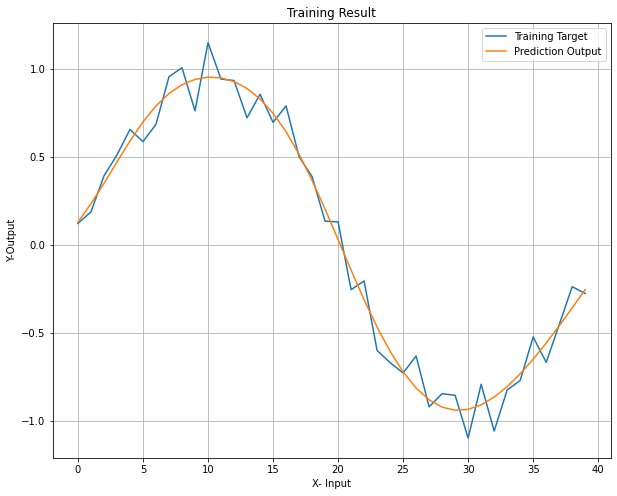

In [7]:
plt.figure(figsize=(10,8))
plt.plot(X.detach().numpy()[:,0],Y.detach().numpy()[:,0])
plt.plot(X.detach().numpy()[:,0],Ypred.detach().numpy()[:,0])
plt.legend(('Training Target', 'Prediction Output'))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Training Result')
plt.grid()

We see that we get indeed a smoothed version of the training set, which means our network is somewhat robust against the noise on the training set.

The plot for the validation set is:

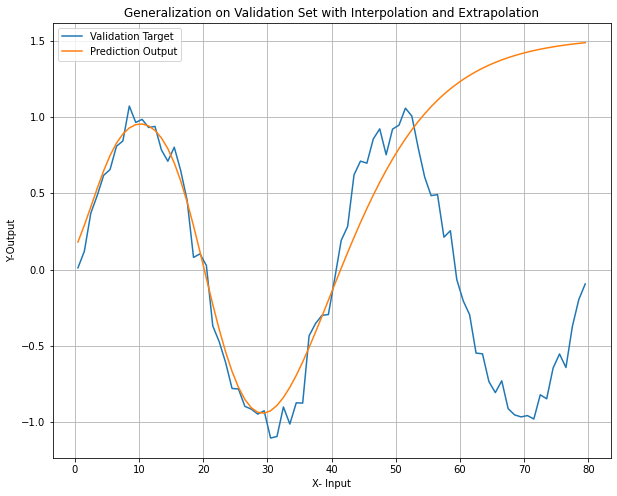

In [8]:
plt.figure(figsize=(10,8))
plt.plot(Xval.detach().numpy()[:,0],Yval.detach().numpy()[:,0])
plt.plot(Xval.detach().numpy()[:,0],Yvalpred.detach().numpy()[:,0])
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Generalization on Validation Set with Interpolation and Extrapolation')
plt.legend(('Validation Target', 'Prediction Output'))
plt.grid()

We see that we have a good interpolation on the X range of the training set, but the extrapolation beyond this training range is not really working.

The resulting function from the network is the sum of the functions of the N nodes.

To see the functions of the individual nodes, we can just keep their weight unchanged, set the others to zero, and plot the resulting function. For that we make mask with zeros for the weights of layer 2, except for one node, and plot the function. Then we repeat this for every node in a "for" loop,

weights= OrderedDict([('layer1.0.weight', tensor([[ 0.2415],
        [ 0.4047],
        [-0.1126],
        [ 1.2180],
        [-0.2518],
        [ 0.3115],
        [-0.2332],
        [ 0.2300],
        [ 0.0528],
        [ 0.0581]])), ('layer1.0.bias', tensor([-6.1918, -1.1939,  4.0242,  2.5634,  4.6787, -4.4766,  4.9360, -4.1202,
        -0.3480, -1.1558])), ('layer2.0.weight', tensor([[-0.6395,  1.1527, -4.2448,  0.1207,  2.1938,  0.7608,  1.6130, -0.3682,
          0.2043,  0.3181]])), ('layer2.0.bias', tensor([-0.0184]))])
model.state_dict()['layer2.0.weight']= tensor([[-0.6395,  1.1527, -4.2448,  0.1207,  2.1938,  0.7608,  1.6130, -0.3682,
          0.2043,  0.3181]])


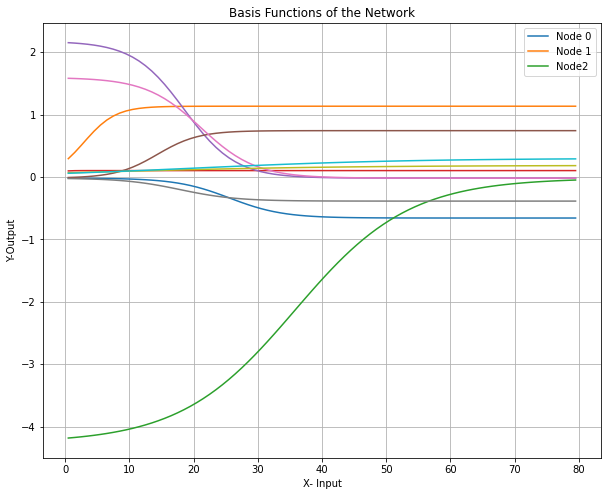

In [9]:
weights = model.state_dict()   #read obtained weights
print("weights=", weights)
#Weights of layer 2:
layer2weights=model.state_dict()['layer2.0.weight'].clone() #clone(), otherwise it is just a pointer!
print("model.state_dict()['layer2.0.weight']=", layer2weights)
   
#The resulting function from the network is the sum of the functions of the N nodes.
#To see the functions of the individual nodes, we can just keep their weight unchanged, 
#set the others to zero, and plot the resulting function.
#For that we make mask with zeros for the weights of layer 2, except for one node:

plt.figure(figsize=(10,8))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Basis Functions of the Network')

for node in range(0,Nodes):
    weightmask=torch.zeros(layer2weights.shape) #mask with all zeros for output layer, except one.
    weightmask[0,node]=1.0 #node "node" unchanged
    #print("weightmask",weightmask)
    #print("layer2weights=",layer2weights)
    #print("layer2weights*weightmask=", layer2weights*weightmask)
    model.state_dict()['layer2.0.weight'].data.copy_(layer2weights*weightmask) #write pytorch structure back to model
    #print("Xval=", Xval)
    Ypred1node=model(Xval) # Make Predictions based on the 1-node weights 
    #print("Ypred1node=", Ypred1node)
    #Plot modified 1-node model:
    plt.plot(Xval.detach().numpy()[:,0],Ypred1node.detach().numpy()[:,0])
plt.grid()      
plt.legend(('Node 0', 'Node 1', 'Node2'));
 #We see the activation function fit with bias and weight 
#to different parts of the target function


We see the activation function of each node is fit with bias and weight to different parts of the target function. Since the activation function is only fitted over the training range, they all become flat after that, and hence their sum also becomes constant.

## Deep Function Approximator

In [18]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/iqFrQbKNdO4?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Instead of having a relatively flat network with only 3 layers, we can now distribute or nodes over more layers, each containing fewer nodes. In this way we obtain a more narrow and deeper network.

In the example we have 5 layers, or 4 linear layers, but each layer has only 2 nodes, so the total number of nodes is similar:

<img src='./images/02_02_neuralNetsApproDeep.png' width='800'>


In [11]:
"""
Simple program to use a fully connected linear neural network layer as a 1-dimensional faunction y=f(x) approximator, using a deep network of several smaller layers instead of a wide layer.
This could be for instance an audio signal, x would be the time, y would be the audio signal value.
Gerald Schuller, Jan. 2020.
--------------------------------------------
Ported to Jupyter Notebook by Renato Profeta, Auguts 2020
"""

import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

device='cpu'
#device='cuda'

N=40 #number of samples in our signal
Nodes=2 #Nodes in each layer
#Nodes=80  #this can result in over-fitting

#A multi-layer fully connected network, 1 input (time value), hidden layer has Nodes nodes, 1 output (function value).

class LinNet(nn.Module):
    #define and initialize the layers:
    def __init__(self):
        super(LinNet, self).__init__()
        # Define the model. 
        #https://pytorch.org/docs/stable/nn.html?highlight=linear#torch.nn.Linear  
        # Generate a fully connected linear neural network model, 2 layers, bias
        # returns: Trainable object
        self.layer1=nn.Sequential(nn.Linear(in_features=1, out_features=Nodes, bias=True))
        self.layer2=nn.Sequential(nn.Linear(in_features=Nodes, out_features=Nodes, bias=True))
        self.layer3=nn.Sequential(nn.Linear(in_features=Nodes, out_features=Nodes, bias=True))
        self.layer4=nn.Sequential(nn.Linear(in_features=Nodes, out_features=1, bias=True))
      
        #self.act = nn.LeakyReLU() #non-linear activation function
        #self.act = nn.ReLU() #non-linear activation function
        #self.act = nn.Hardtanh() #non-linear activation function
        self.act = nn.Sigmoid() #non-linear activation function
      
        #Putting the network together:
    def forward(self, x):
        out = self.layer1(x)
        #print("out.shape=", out.shape)
        out = self.act(out)  #comment out if not desired
        #print("out.shape=", out.shape)
        out = self.layer2(out)
        #print("out.shape=", out.shape)
        out = self.act(out)
        out = self.layer3(out)
        out = self.act(out)
        out = self.layer4(out)
        return out

In [12]:
print("Number of input samples:", N, "number of nodes:", Nodes)
#input tensor, type torch tensor:
#Indices: batch, additional dimensions, features or signal dimension. Here: 1 batch, 3 samples, signal dimension 2: 
#Training set:
#The x input here is the time:
X=torch.arange(0,N,1.0) #generates N time steps for X
X=X.view(N,1) #adding the last dimension for the signal (1 sample each), first dimension for the batch of size N
print("X.shape", X.shape)
#Target here is the (noisy) function value, a sine function + normal distributed random values:
#Y=torch.sin(X)+torch.empty(X.shape).normal_(std=0.5)
Y=torch.sin(X*3.14/N*2)+torch.randn(X.shape)*0.1
#2 periods of the sinusoid in our training set, plus noise
#Y=Y.view(N,1)
print("Y.shape", Y.shape)
#Validation set, to test generalization, with new noise:
Xval=torch.arange(0.5,2*N,1.0) #generates 2N time steps for X for extrapolation beyond N,
#shifted by 0.5 compared to training set, 
#for interpolation between the original sample points.
#print("Xval=", Xval)
Xval=Xval.view(2*N,1)
#Validation Target:
Yval=torch.sin(Xval*3.14/N*2)+torch.randn(Xval.shape)*0.1
#Yval=Yval.view(2*N,1)
   
#create network object:
model = LinNet().to(device)
#Before training:
Ypred=model(X) #the model produces prediction output
print("Ypred.shape=", Ypred.shape)
weights = model.state_dict()   #read obtained weights
print("initial weights=", weights)  #see the random initialization of the weights 
   
#print("model.parameters()=", model.parameters()) 
   
print("Define loss function:")
loss_fn = nn.MSELoss() #mean squared error loss
   
print("Define optimizer:")
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
print("Optimizing:")
for epoch in range(150000):
    Ypred=model(X) #the model produces prediction output
    loss=loss_fn(Ypred, Y) #prediction and target compared by loss
    if epoch%1000==0:
        print(epoch, loss.item()) #print current loss value
    optimizer.zero_grad() #optimizer sets previous gradients to zero
    loss.backward() #optimizer computes new gradients
    optimizer.step() #optimizer updates weights
       
Ypred=model(X) # Make Predictions based on the obtained weights 
#print("Ypred training set=", Ypred) 
loss=loss_fn(Ypred, Y)
print("Loss on trainig set:", loss.detach().numpy())


Number of input samples: 40 number of nodes: 2
X.shape torch.Size([40, 1])
Y.shape torch.Size([40, 1])
Ypred.shape= torch.Size([40, 1])
initial weights= OrderedDict([('layer1.0.weight', tensor([[0.6335],
        [0.5824]])), ('layer1.0.bias', tensor([ 0.7903, -0.4966])), ('layer2.0.weight', tensor([[-0.0342, -0.3927],
        [-0.2804, -0.2727]])), ('layer2.0.bias', tensor([-0.2253, -0.2949])), ('layer3.0.weight', tensor([[-0.6515,  0.1173],
        [ 0.2142,  0.1056]])), ('layer3.0.bias', tensor([-0.5080,  0.0027])), ('layer4.0.weight', tensor([[ 0.5748, -0.4883]])), ('layer4.0.bias', tensor([0.6975]))])
Define loss function:
Define optimizer:
Optimizing:
0 0.9441583752632141
1000 0.5360969305038452
2000 0.431851863861084
3000 0.05436243861913681
4000 0.045526884496212006
5000 0.044754479080438614
6000 0.044330477714538574
7000 0.04409246891736984
8000 0.043904051184654236
9000 0.04363683983683586
10000 0.04311113804578781
11000 0.04235917702317238
12000 0.04145287722349167
13000 0.04

It turns out that the adam optimizer now needs many more iterations, 150000, instead of just 10000, hence 15 times as long, but the resulting function approximation seems to be more smooth. This is an **advantage for the generalization**, observe that the validation set now has a very similar loss as the training set.

It plots the following result for the training set:

plt.figure(figsize=(10,8))
plt.plot(X.detach().numpy()[:,0],Y.detach().numpy()[:,0])
plt.plot(X.detach().numpy()[:,0],Ypred.detach().numpy()[:,0])
plt.legend(('Training Target', 'Prediction Output'))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Training Result')
plt.grid()
Yvalpred=model(Xval) # Make Predictions based on the obtained weights 
#print("Y validation set=", Yvalpred.detach().numpy()) 
loss=loss_fn(Yvalpred[:N,:], Yval[:N,:])
print("Loss on validation set:", loss.detach().numpy())


Observe that the optimization has a harder time to fit the function, despite the 15 times more iterations. But often it is found that deep networks are better for the generalization, which should give the Loss for the validation and test similar values as for training.

It plots the following for the validation set:

weights= OrderedDict([('layer1.0.weight', tensor([[0.1475],
        [0.5575]])), ('layer1.0.bias', tensor([-3.5223, -2.4937])), ('layer2.0.weight', tensor([[12.1843, -4.3992],
        [10.8847, -8.8776]])), ('layer2.0.bias', tensor([ 0.6582, -2.2007])), ('layer3.0.weight', tensor([[-1.5357,  5.1039],
        [19.0651, 95.6845]])), ('layer3.0.bias', tensor([ -1.7864, -18.6451])), ('layer4.0.weight', tensor([[16.3941, -0.7664]])), ('layer4.0.bias', tensor([-0.9849]))])
model.state_dict()['layer2.0.weight']= tensor([[12.1843, -4.3992],
        [10.8847, -8.8776]])


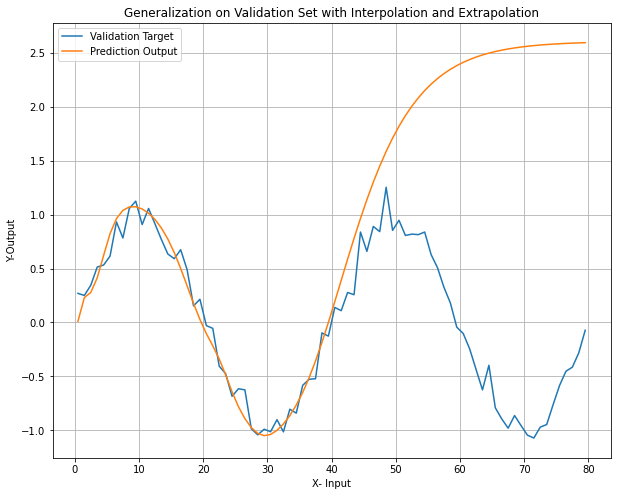

In [14]:
plt.figure(figsize=(10,8))
plt.plot(Xval.detach().numpy()[:,0],Yval.detach().numpy()[:,0])
plt.plot(Xval.detach().numpy()[:,0],Yvalpred.detach().numpy()[:,0])
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Generalization on Validation Set with Interpolation and Extrapolation')
plt.legend(('Validation Target', 'Prediction Output'))
plt.grid()
   
weights = model.state_dict()   #read obtained weights
print("weights=", weights)
#Weights of layer 2:
layer2weights=model.state_dict()['layer2.0.weight'].clone() #clone(), otherwise it is just a pointer!
print("model.state_dict()['layer2.0.weight']=", layer2weights)
   

We see that it does a reasonable interpolation, with a smooth curve fitting.

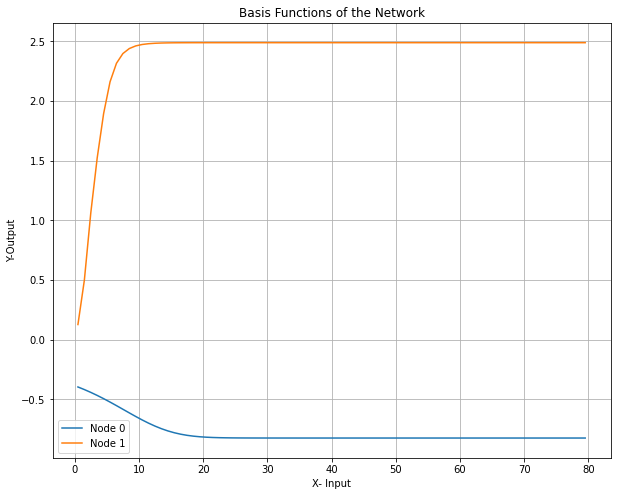

In [15]:
#The resulting function from the network is the sum of the functions of the N nodes.
#To see the functions of the individual nodes, we can just keep their weight unchanged, 
#set the others to zero, and plot the resulting function.
#For that we make mask with zeros for the weights of layer 2, except for one node:

plt.figure(figsize=(10,8))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Basis Functions of the Network')
for node in range(0,Nodes):
    weightmask=torch.zeros(layer2weights.shape) #mask with all zeros for output layer, except one.
    weightmask[0,node]=1.0 #node "node" unchanged
    #print("weightmask",weightmask)
    #print("layer2weights=",layer2weights)
    #print("layer2weights*weightmask=", layer2weights*weightmask)
    model.state_dict()['layer2.0.weight'].data.copy_(layer2weights*weightmask) #write pytorch structure back to model
    #print("Xval=", Xval)
    Ypred1node=model(Xval) # Make Predictions based on the 1-node weights 
    #print("Ypred1node=", Ypred1node)
    #Plot modified 1-node model:
    plt.plot(Xval.detach().numpy()[:,0],Ypred1node.detach().numpy()[:,0])
      
#plt.legend(('Validation Target', 'Prediction Output', 'Node 0', 'Node 5'))
plt.legend(('Node 0', 'Node 1', 'Node2'))
plt.grid()
#We see the activation function fit with bias and weight 
#to different parts of the target function